In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Vertical Edge

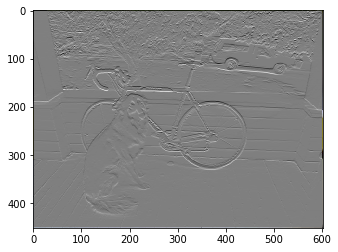

In [12]:
#define the vertical filter
vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

img = plt.imread('edge-detection.png')

#get the dimensions of the image
h,w,c = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, h-2):
    for col in range(3, w-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2, 0]
        
        #apply the vertical filter
        vertical_transformed_pixels = vertical_filter*local_pixels
        #remap the vertical score
        vertical_score = (vertical_transformed_pixels.sum() + 4)/8
        
        #insert this edge score into the edges image
        edges_img[row, col] = [vertical_score]*3
        
#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()

plt.imshow(edges_img)

In [13]:
# Horizontal Edge

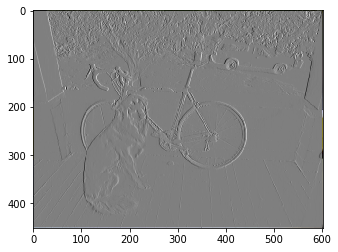

In [14]:
#define the horizontal filter
horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

#read in the pinwheel image
img = plt.imread('edge-detection.png')

#get the dimensions of the image
h,w,c = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, h-2):
    for col in range(3, w-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2, 0]
        
        #apply the horizontal filter
        horizontal_transformed_pixels = horizontal_filter*local_pixels
        #remap the horizontal score
        horizontal_score = (horizontal_transformed_pixels.sum() + 4)/8
        
        #insert this edge score into the edges image
        edges_img[row, col] = [horizontal_score]*3

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()

plt.imshow(edges_img)

In [15]:
# Sobel Edge

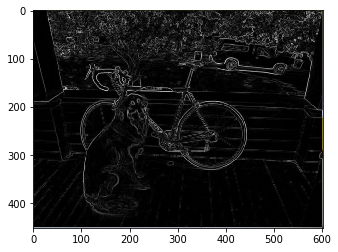

In [16]:
#define the vertical filter
vertical_filter = [[-1,-2,-1], [0,0,0], [1,2,1]]

#define the horizontal filter
horizontal_filter = [[-1,0,1], [-2,0,2], [-1,0,1]]

#read in the pinwheel image
img = plt.imread('edge-detection.png')

#get the dimensions of the image
h,w,c = img.shape

#initialize the edges image
edges_img = img.copy()

#loop over all pixels in the image
for row in range(3, h-2):
    for col in range(3, w-2):
        
        #create little local 3x3 box
        local_pixels = img[row-1:row+2, col-1:col+2, 0]
        
        #apply the vertical filter
        vertical_transformed_pixels = vertical_filter*local_pixels
        #remap the vertical score
        vertical_score = vertical_transformed_pixels.sum()/4
        
        #apply the horizontal filter
        horizontal_transformed_pixels = horizontal_filter*local_pixels
        #remap the horizontal score
        horizontal_score = horizontal_transformed_pixels.sum()/4
        
        #combine the horizontal and vertical scores into a total edge score
        edge_score = (vertical_score**2 + horizontal_score**2)**.5
        
        #insert this edge score into the edges image
        edges_img[row, col] = [edge_score]*3

#remap the values in the 0-1 range in case they went out of bounds
edges_img = edges_img/edges_img.max()

plt.imshow(edges_img)

In [17]:
# Canny Edge Detection

In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def applyKernel(image, kernel):
    padded_image = np.zeros((image.shape[0]+kernel.shape[0]-1,image.shape[1] + kernel.shape[1]-1))
    padded_image[kernel.shape[0]-2:-1:,kernel.shape[1]-2:-1:] = image
    padded_image[0,0]=image[0,0]
    padded_image[-1,-1]=image[-1,-1]
    filtered_image = np.zeros_like(image)
    for w in range(image.shape[1]):
        for h in range(image.shape[0]):
                xstart = w
                xend = w + kernel.shape[0]
                ystart = h
                yend = h + kernel.shape[1]
                image_slice = padded_image[ystart: yend , xstart: xend]
                product = kernel * image_slice
                totalsum = np.sum(product)
                filtered_image[h, w] = totalsum
    return filtered_image

In [20]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [21]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [22]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [23]:
img = np.array(Image.open("edge-detection2.jpg"))


r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
gray_img = 0.2989 * r + 0.5870 * g + 0.1140 * b

gaussian_kernel = np.array([[1 / 256, 4  / 256,  6 / 256,  4 / 256, 1 / 256],
                   [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
                   [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
                   [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
                   [1 / 256, 4  / 256,  6 / 256,  4 / 256, 1 / 256]])

# 1. Applying gaussian blur for noise reduction
gaussfiltered = applyKernel(gray_img, gaussian_kernel)



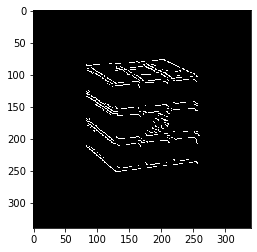

In [24]:
#define the vertical filter
vertical_filter = np.array([[-1,-2,-1], [0,0,0], [1,2,1]] , np.float32)

#apply the horizontal filter
horizontal_filter = np.array([[-1,0,1], [-2,0,2], [-1,0,1]] , np.float32)


# 2. Sobel filters for gradient descent
intensity_x = applyKernel(gaussfiltered, vertical_filter)

intensity_y = applyKernel(gaussfiltered, vertical_filter)

total_intensity = np.hypot(intensity_x, intensity_y)

total_intensity = total_intensity / total_intensity.max() * 255

theta = np.arctan2(intensity_y, intensity_x)

# 3. Non-max Suppression
non_maximg = non_max_suppression(total_intensity, theta)

# 4. Double Threshold
threshold_img = threshold(non_maximg)

# 5. Edge Tracking by Hysteresis
final_img = hysteresis(threshold_img[0], threshold_img[1], threshold_img[2])

canny_edge = Image.fromarray(final_img).convert('RGB')
plt.imshow(canny_edge)
canny_edge.save('canny_edge.jpg')